In [1]:
%cd ..
import ROOT
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from melp import Detector
import melp
import math
import random
import matplotlib.colors as colors

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt
import melp.clustering.three_frame_cluster as clump_3

plt.rcParams.update({'font.size': 16})
plt.style.use('seaborn-dark')


/home/erik/git_repoitories/melp
Welcome to JupyROOT 6.26/06


## Classes

In [2]:
import dataclasses

#cluster hit class
@dataclasses.dataclass
class ClusterHit:
    tile_id: int
    frame_id: int = -1
    time: float = -1
    edep: float = -1

#cluster class
@dataclasses.dataclass
class Cluster:
    id: int
    frame_id: int
    master_id: int
    hits: list = dataclasses.field(default_factory=list)
    
    # -----------------------------------------
    #  public functions
    # -----------------------------------------

    #returns True if the two clusters are the same
    def __eq__(self, other):
        if len(self.hits) == len(other.hits) and self.frame_id == other.frame_id and self.get_tile_ids() == other.get_tile_ids():
            return True
        else:
            return False
        #return self.id == other.id

    #returns the cluster id and the number of hits in the cluster
    #def __str__(self):
    #    return (f'Cluster: ID={self.id}, # Hits={len(self.hits)}')

    #returns the number of hits in the cluster
    def __len__(self):
        return len(self.hits)
    
    #returns all tile ids in cluster
    def get_tile_ids(self):
        tile_ids = []
        for hit in self.hits:
            tile_ids.append(hit.tile_id)
        return tile_ids
    
    #returns all times in cluster
    def get_times(self):
        times = []
        for hit in self.hits:
            times.append(hit.time)
        return times
    
    #returns all edeps in cluster
    def get_edeps(self):
        edeps = []
        for hit in self.hits:
            edeps.append(hit.edep)
        return edeps

    #return all frame ids in cluster
    def get_frame_ids(self):
        frame_ids = []
        for hit in self.hits:
            frame_ids.append(hit.frame_id)
        return frame_ids

    #return the value and index of hit with smallest time in cluster
    def get_min_time(self):
        times = []
        for hit in self.hits:
            times.append(hit.time) 
        val, idx = min((val, idx) for (idx, val) in enumerate(times))
        return self.hits[idx], idx
    
    #return the mean time of cluster 
    def get_mean_time(self):
        times = []
        for hit in self.hits:
            times.append(hit.time)
        mean_time = sum(times)/len(times)
        return mean_time
        
    #return list with all time differences in cluster
    def get_time_diffs(self):
        times = []
        time_diffs = []
        for hit in self.hits:
            times.append(hit.time)
        for i in times:
            for j in times:
                if j != i:
                    time_diffs.append(np.abs(i-j))
        return time_diffs
    
    #return mean energy deposition
    def get_mean_edep(self):
        edeps = []
        for hit in self.hits:
            edeps.append(hit.edep)
        average_edep = sum(edeps)/len(edeps)
        return average_edep
        

In [3]:
#get mu3e detector info from simulation file
filename_sorted_sim = "./testdata/sorted/sorted1.root"

file_sim = ROOT.TFile(filename_sorted_sim)
ttree_mu3e_sim = file_sim.Get("mu3e")

mu3e_detector = Detector.initFromROOT(filename_sorted_sim)

melp.select(mu3e_detector)
print(mu3e_detector)

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------
Detector(TileDetector=Loaded Tiles: 5824, SensorModules=<melp.src.sensor.SensorModule object at 0x7f5abbb7bdf0>))


In [4]:
#open tree with testbeam stuff
filename_sorted = "./testdata/sorted/mu3eTree02604_new_new.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")

In [30]:
#select frame to analyze
frame_used =  137448 #343 #35 #28 #343 #29 #182
ttree_mu3e.GetEntry(frame_used)
#set time threshold 
time_threshold_used = 10 #1.2 #ns

# Time then iterative spatial masks

In [6]:
def time_clustering_frame_improv_testbeam(ttree_mu3e, frame: int, time_threshold: float = 0.4) -> dict:
    indices           = np.argsort(list(ttree_mu3e.tilehit_time))
    tilehit_times     = np.asarray(list(ttree_mu3e.tilehit_time))[indices]
    tilehit_ids       = np.asarray(list(ttree_mu3e.tilehit_tile))[indices]
    tilehit_edeps     = np.asarray(list(ttree_mu3e.tilehit_edep))[indices]

    if len(tilehit_times) == 0:
        return [Cluster(id=-1, frame_id=frame, master_id=-1, hits=[])]
    
    else:
        clusters_dict = {}
        tmp_time_reference = tilehit_times[0]
        index_start_track = 0
        for index in range(len(tilehit_times)):
            if abs(tmp_time_reference - tilehit_times[index]) > time_threshold:
                clusters_dict[index] = [tilehit_ids[index_start_track:index], tilehit_times[index_start_track:index], tilehit_edeps[index_start_track:index]]
                index_start_track = index
                tmp_time_reference = tilehit_times[index]

        #fill up remaining event
        if index_start_track != len(tilehit_times):
            clusters_dict[len(tilehit_times)] = [tilehit_ids[index_start_track:],
                                                tilehit_times[index_start_track:],
                                                tilehit_edeps[index_start_track:]]

        #convert to cluster object
        clusters = []
        for key in clusters_dict.keys():
            cluster_tmp = []
            for i in range(len(clusters_dict[key][0])):         
                cluster_tmp.append(ClusterHit(tile_id=clusters_dict[key][0][i], frame_id=frame, time=clusters_dict[key][1][i], edep=clusters_dict[key][2][i]))
            clusters.append(Cluster(id=key, frame_id=frame, master_id=cluster_tmp[0].tile_id, hits=cluster_tmp))

    return clusters

In [7]:
def build_mask_single_hit_testbeam(cluster_hit: ClusterHit, ttree_mu3e, mu3e_detector: melp.Detector, frame, mask_type, rec_type = None):
    #-----------------
    #build small masks
    #-----------------
    if mask_type == "small":
        tile_centre        = cluster_hit.tile_id
        tile_centre_top    = mu3e_detector.TileDetector.getNeighbour(tile_centre, "up")
        tile_centre_bottom = mu3e_detector.TileDetector.getNeighbour(tile_centre, "down")
        tile_left_centre   = mu3e_detector.TileDetector.getNeighbour(tile_centre, "left")
        tile_right_centre  = mu3e_detector.TileDetector.getNeighbour(tile_centre, "right")

        mask_tmp = np.array([tile_centre, tile_centre_top, tile_centre_bottom, 
                            tile_left_centre, tile_right_centre])

        if False in mask_tmp:
            mask_tmp = [x for x in mask_tmp if x != False]

    #------------------
    #build medium masks
    #------------------
    if mask_type == "medium":
        tile_centre        = cluster_hit.tile_id
        tile_centre_top    = mu3e_detector.TileDetector.getNeighbour(tile_centre, "up")
        tile_centre_bottom = mu3e_detector.TileDetector.getNeighbour(tile_centre, "down")
        tile_left_centre   = mu3e_detector.TileDetector.getNeighbour(tile_centre, "left")
        tile_left_top      = mu3e_detector.TileDetector.getNeighbour(tile_left_centre, "up")
        tile_left_bottom   = mu3e_detector.TileDetector.getNeighbour(tile_left_centre, "down")
        tile_right_centre  = mu3e_detector.TileDetector.getNeighbour(tile_centre, "right")
        tile_right_top     = mu3e_detector.TileDetector.getNeighbour(tile_right_centre, "up")
        tile_right_bootom  = mu3e_detector.TileDetector.getNeighbour(tile_right_centre, "down")

        mask_tmp = np.array([tile_centre, tile_centre_top, tile_centre_bottom, tile_left_top, 
                            tile_left_centre, tile_left_bottom, tile_right_top, tile_right_centre, 
                            tile_right_bootom])

        if False in mask_tmp:
            mask_tmp = [x for x in mask_tmp if x != False]

    #---------------
    #build big masks
    #---------------
    if mask_type == "big":
        tile_centre            = cluster_hit.tile_id
        tile_centre_top        = mu3e_detector.TileDetector.getNeighbour(tile_centre, "up")
        tile_centre_bottom     = mu3e_detector.TileDetector.getNeighbour(tile_centre, "down")
        tile_left_centre       = mu3e_detector.TileDetector.getNeighbour(tile_centre, "left")
        tile_left_top          = mu3e_detector.TileDetector.getNeighbour(tile_left_centre, "up")
        tile_left_bottom       = mu3e_detector.TileDetector.getNeighbour(tile_left_centre, "down")
        tile_right_centre      = mu3e_detector.TileDetector.getNeighbour(tile_centre, "right")
        tile_right_top         = mu3e_detector.TileDetector.getNeighbour(tile_right_centre, "up")
        tile_right_bottom      = mu3e_detector.TileDetector.getNeighbour(tile_right_centre, "down")

        tile_centre_far_top    = mu3e_detector.TileDetector.getNeighbour(tile_centre_top, "up")
        tile_centre_far_bottom = mu3e_detector.TileDetector.getNeighbour(tile_centre_bottom, "down")
        tile_left_far_centre   = mu3e_detector.TileDetector.getNeighbour(tile_left_centre, "left")
        tile_left_far_top      = mu3e_detector.TileDetector.getNeighbour(tile_left_top, "up")
        tile_left_far_bottom   = mu3e_detector.TileDetector.getNeighbour(tile_left_bottom, "down")
        tile_right_far_centre  = mu3e_detector.TileDetector.getNeighbour(tile_right_centre, "right")
        tile_right_far_top     = mu3e_detector.TileDetector.getNeighbour(tile_right_top, "up")
        tile_right_far_bottom  = mu3e_detector.TileDetector.getNeighbour(tile_right_bottom, "down")

        tile_far_left_top      = mu3e_detector.TileDetector.getNeighbour(tile_left_top, "left")
        tile_far_left_bottom   = mu3e_detector.TileDetector.getNeighbour(tile_left_bottom, "left")
        tile_far_right_top     = mu3e_detector.TileDetector.getNeighbour(tile_right_top, "right")
        tile_far_right_bottom  = mu3e_detector.TileDetector.getNeighbour(tile_right_bottom, "right")

        mask_tmp = np.array([tile_centre, tile_centre_top, tile_centre_bottom, tile_left_top, tile_left_centre, tile_left_bottom,
                                tile_right_top, tile_right_centre, tile_right_bottom, tile_centre_far_top, tile_centre_far_bottom, 
                                tile_left_far_centre, tile_left_far_top, tile_left_far_bottom, tile_right_far_centre, 
                                tile_right_far_top, tile_right_far_bottom, tile_far_left_top, tile_far_left_bottom, tile_far_right_top, 
                                tile_far_right_bottom])

        if False in mask_tmp:
            mask_tmp = [x for x in mask_tmp if x != False]

    return mask_tmp

In [8]:
def iterative_masks_after_time_clustering_testbeam(ttree_mu3e, mu3e_detector: melp.Detector, frame, time_threshold, mask_type, rec_type = None):
    #-----------------------------------------------
    #use time cluster as first rough cut / reference
    #-----------------------------------------------
    #without energy cut
    time_clusters = time_clustering_frame_improv_testbeam(ttree_mu3e, frame, time_threshold)

    #-----------------------------------------------------------------------
    #get all tiles that have been hit in frame and their primaries and times
    #-----------------------------------------------------------------------
    hit_tiles_frame = []
    times_frame     = []
    edeps_frame     = []

    for hit_tile_index in range(ttree_mu3e.Ntilehit):
        hit_tiles_frame.append(ttree_mu3e.tilehit_tile[hit_tile_index])
        times_frame.append(ttree_mu3e.tilehit_time[hit_tile_index])
        edeps_frame.append(ttree_mu3e.tilehit_edep[hit_tile_index])

    #-------------------------
    #build iterative masks
    #-------------------------
    new_clusters = []
    for time_cluster in time_clusters:  #loop over all clusters
        added_hits = [] #just tile_ids
        for i in range(len(time_cluster.hits)):  #loop over all hits in cluster  
            cluster_tmp = []  
            remaining_hits = []
            if time_cluster.hits[i].tile_id not in added_hits:
                mask_tmp = build_mask_single_hit_testbeam(time_cluster.hits[i], ttree_mu3e, 
                                                          mu3e_detector, frame, mask_type, rec_type = None)
                for j in range(len(time_cluster.hits)):
                    if time_cluster.hits[j].tile_id in mask_tmp and time_cluster.hits[j].tile_id not in added_hits: 
                        cluster_tmp.append(ClusterHit(tile_id = time_cluster.hits[j].tile_id, frame_id = frame, time = time_cluster.hits[j].time, edep = time_cluster.hits[j].edep))
                        added_hits.append(time_cluster.hits[j].tile_id)
            #build mask around hits in first cluster
            cluster_tmp_2 = []
            if len(cluster_tmp) != 0:
                for hit_tmp in cluster_tmp:
                    next_mask_tmp = build_mask_single_hit_testbeam(hit_tmp, ttree_mu3e, 
                                                                   mu3e_detector, frame, mask_type, rec_type = None)
                    for m in range(len(time_cluster.hits)):
                        if time_cluster.hits[m].tile_id in next_mask_tmp and time_cluster.hits[m].tile_id not in added_hits: 
                            cluster_tmp.append(ClusterHit(tile_id = time_cluster.hits[m].tile_id, frame_id = frame, time = time_cluster.hits[m].time, edep = time_cluster.hits[m].edep))
                            cluster_tmp_2.append(ClusterHit(tile_id = time_cluster.hits[m].tile_id, frame_id = frame, time = time_cluster.hits[m].time, edep = time_cluster.hits[m].edep))
                            added_hits.append(time_cluster.hits[m].tile_id)

            #build mask around hits in second iteration clusters
            cluster_tmp_3 = []
            if len(cluster_tmp_2) != 0:
                for hit_tmp_2 in cluster_tmp_2:
                    next_mask_tmp_2 = build_mask_single_hit_testbeam(hit_tmp_2, ttree_mu3e, mu3e_detector, frame, mask_type, rec_type = None)
                    for m in range(len(time_cluster.hits)):
                        if time_cluster.hits[m].tile_id in next_mask_tmp_2 and time_cluster.hits[m].tile_id not in added_hits: 
                            cluster_tmp.append(ClusterHit(tile_id = time_cluster.hits[m].tile_id, frame_id = frame, time = time_cluster.hits[m].time, edep = time_cluster.hits[m].edep))
                            cluster_tmp_3.append(ClusterHit(tile_id = time_cluster.hits[m].tile_id, frame_id = frame, time = time_cluster.hits[m].time, edep = time_cluster.hits[m].edep))
                            added_hits.append(time_cluster.hits[m].tile_id)

            if len(cluster_tmp) != 0:
                cluster_tmp_times = []
                for hit in cluster_tmp:
                    cluster_tmp_times.append(hit.time)
                index_min_time = np.argmin(cluster_tmp_times)
                new_clusters.append(Cluster(id = cluster_tmp[index_min_time].tile_id, master_id = cluster_tmp[index_min_time].tile_id, 
                                            frame_id = frame, hits = cluster_tmp))



    return new_clusters

In [9]:
clusters = iterative_masks_after_time_clustering_testbeam(ttree_mu3e, mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "medium", rec_type = None)
hits_in_clusters = 0
for cluster in clusters:
    hits_in_clusters += cluster.__len__()
    
print("#hits in clusters in frame" ,clusters[0].frame_id, "=",hits_in_clusters, )

#hits in clusters in frame 137448 = 21


# Plotting

### Visualize hits in single frame

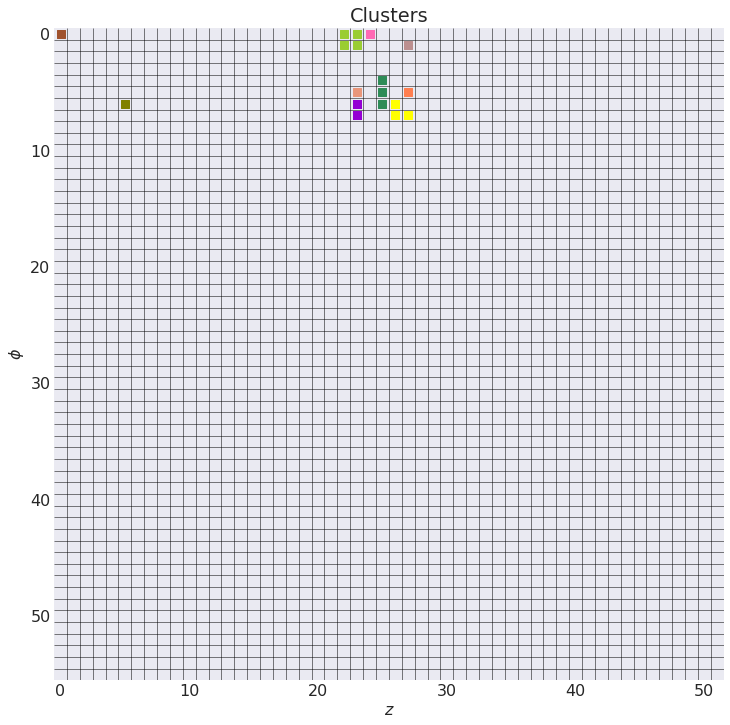

In [10]:
plt.figure(figsize=(12,12))
#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#plot clusters
cluster_grid = np.zeros((52,56))

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral","indianred", "brown", "darkred", "red", "mistyrose", 
              "tomato", "darksalmon", "coral", "orangered", "sienna", "chocolate", "saddlebrown", "peachpuff", 
              "peru", "darkorange", "tan", "orange", "goldenrod", "gold", "khaki", "darkkhaki", "olive",
              "yellow", "olivedrab", "yellowgreen", "darkolivegreen", "greenyellow", "lawngreen", "palegreen", 
              "limegreen", "green", "seagreen", "springgreen", "aquamarine", "turquoise", "paleturquoise", 
              "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "royalblue", "navy", "blue", 
              "slateblue", "blueviolet", "indigo", "darkviolet", "violet", "purple", "magenta", 
              "mediumvioletred", "deeppink", "hotpink", "crimson", "pink"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            plt.scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""

plt.hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
plt.vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
plt.title("Clusters")
plt.xlabel("$z$")
plt.ylabel("$\phi$")
plt.xlim(-0.5,51.5)
plt.ylim(-0.5,55.5)
plt.gca().invert_yaxis()
plt.show()

### Calculation

In [11]:
print("Total number of frames: ",ttree_mu3e.GetEntries())
#frames_to_analyze = ttree_mu3e.GetEntries()
frames_to_analyze = 200000
print("Number of frames to analyze: ",frames_to_analyze)

t_hit_cluster_mean_time             = [] #t_hit - mean_time_cluster
num_hits_cluster_1                  = [] #number of hits in cluster for every hit
num_hits_cluster_2                  = [] #number of hits in cluster for every cluster
average_time_difference_clusterhits = [] #average time difference of hits in a cluster
edeps_per_hit                       = [] #energy depositions of every hit
average_edep_clusterhits            = [] #average energy deposition of hits in single cluster
cluster_time_diff_to_first_hit      = [] #time differences of hits in cluster to first hit
edeps_per_hit_without_first_hit     = [] #energy depositions per hit without the first hit of every cluster

for i in range(frames_to_analyze):
    ttree_mu3e.GetEntry(i)
    #Printing status info
    if i % 5000 == 0:
        print("Progress: ", np.round(i / frames_to_analyze * 100), " %","of ", frames_to_analyze, " frames", end='\r')

    if ttree_mu3e.Ntilehit != 0:
        clusters_plt = iterative_masks_after_time_clustering_testbeam(ttree_mu3e, mu3e_detector, i, time_threshold = time_threshold_used, mask_type = "medium", rec_type = None)
        for cluster_plt in clusters_plt:
            mean_time = cluster_plt.get_mean_time()
            num_hits_cluster_2.append(len(cluster_plt))
            time_diffs_tmp = cluster_plt.get_time_diffs()
            average_edep_clusterhits.append(cluster_plt.get_mean_edep())
            if len(time_diffs_tmp) != 0:
                average_time_difference_clusterhits.append(np.sum(time_diffs_tmp)/len(time_diffs_tmp))
            for time in cluster_plt.get_times():
                t_hit_cluster_mean_time.append(time - mean_time)
                num_hits_cluster_1.append(len(cluster_plt))
            edeps_tmp = cluster_plt.get_edeps()
            for i in range(len(edeps_tmp)):
                edeps_per_hit.append(edeps_tmp[i])
                if i != 0:
                    edeps_per_hit_without_first_hit.append(edeps_tmp[i])
            times_sorted = np.sort(cluster_plt.get_times())
            if len(times_sorted) != 0:
                for i in range(len(times_sorted)):
                    if i > 0:
                        cluster_time_diff_to_first_hit.append(times_sorted[i]-times_sorted[0])

                

Total number of frames:  69080724
Number of frames to analyze:  200000


### $t_{hit}$ - mean time in cluster vs. #hits in cluster

In [12]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

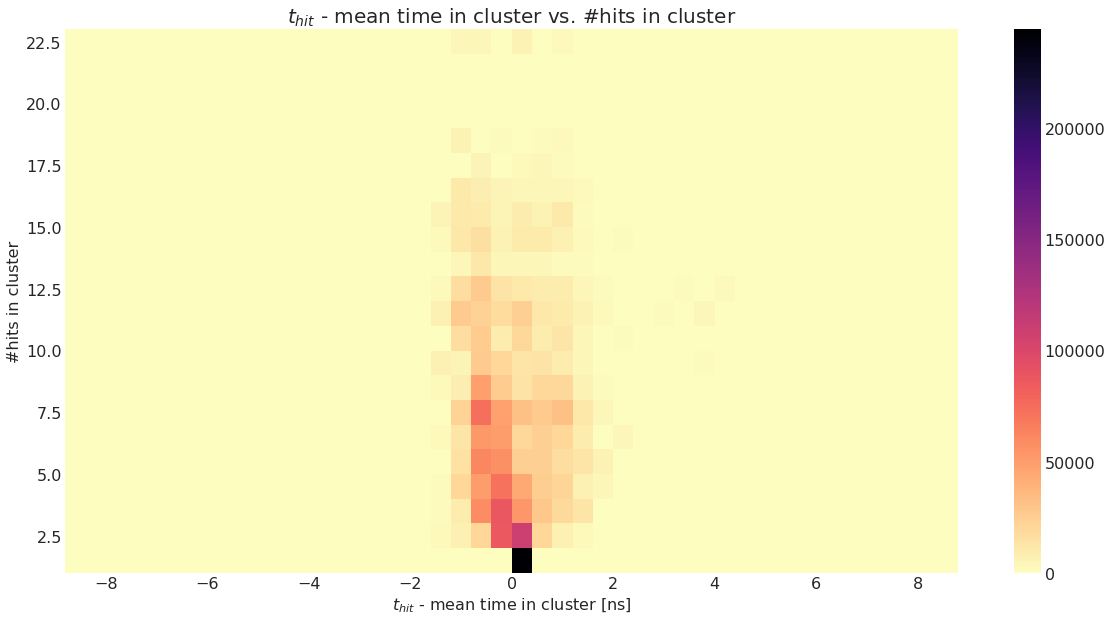

In [13]:
plt.figure(figsize=(20,10))
plt.hist2d(t_hit_cluster_mean_time,num_hits_cluster_1, bins = (compute_histogram_bins(t_hit_cluster_mean_time, 1.6/4),compute_histogram_bins(num_hits_cluster_1,1)), cmap = "magma_r")
plt.colorbar()
plt.title("$t_{hit}$ - mean time in cluster vs. #hits in cluster", fontsize=20)
plt.xlabel("$t_{hit}$ - mean time in cluster [ns]", fontsize=16)
plt.ylabel("#hits in cluster", fontsize=16)
plt.show()

### #number of hits in clusters


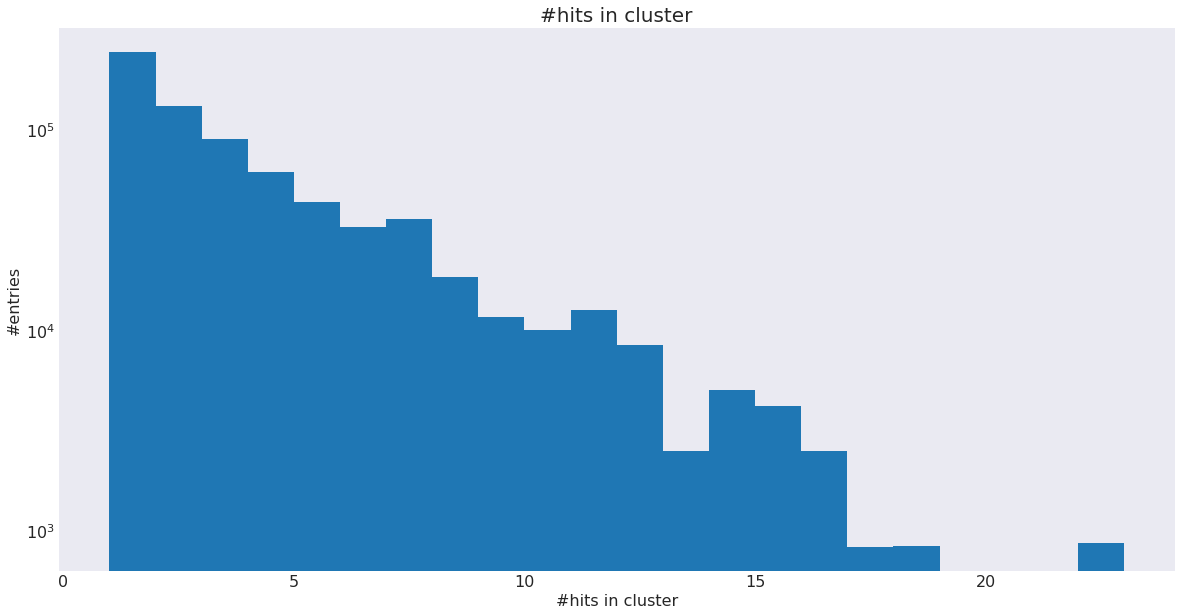

In [14]:
plt.figure(figsize=(20,10))
plt.hist(num_hits_cluster_2, bins = compute_histogram_bins(num_hits_cluster_2,1))
plt.title("#hits in cluster", fontsize = 20)
plt.ylabel("#entries", fontsize = 16)
plt.xlabel("#hits in cluster", fontsize = 16)
plt.yscale("log")
plt.show()

### Average time difference of hits in cluster

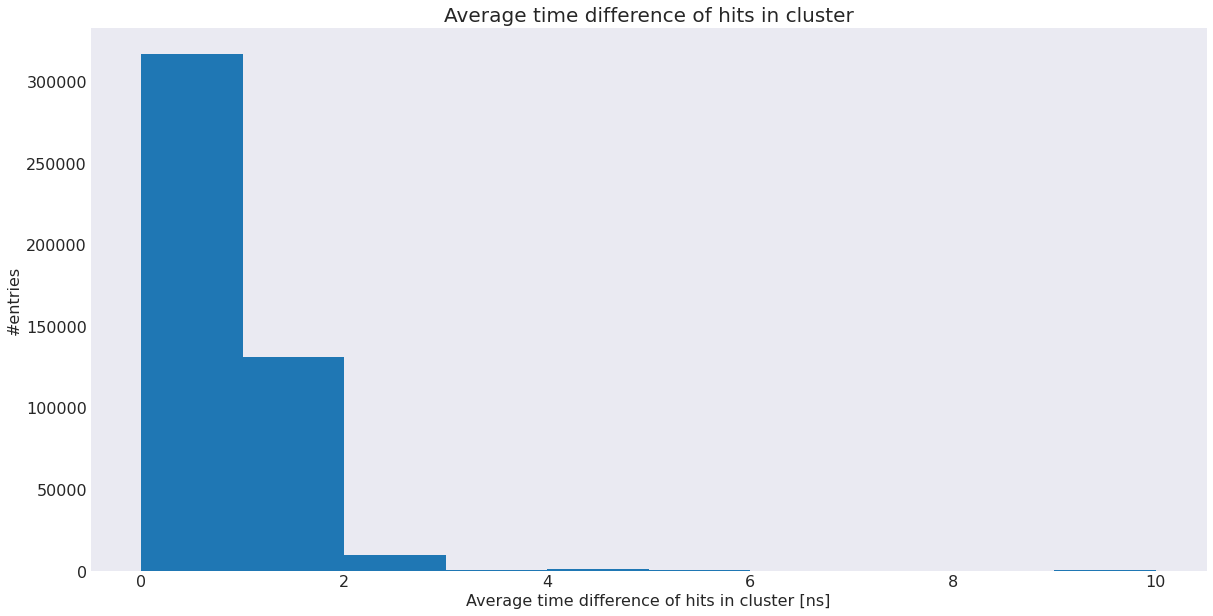

In [15]:
plt.figure(figsize=(20,10))
plt.hist(average_time_difference_clusterhits, bins = compute_histogram_bins(average_time_difference_clusterhits,1))
plt.title("Average time difference of hits in cluster", fontsize = 20)
plt.ylabel("#entries", fontsize = 16)
plt.xlabel("Average time difference of hits in cluster [ns]", fontsize = 16)
plt.show()

### Energy deposition (per hit)

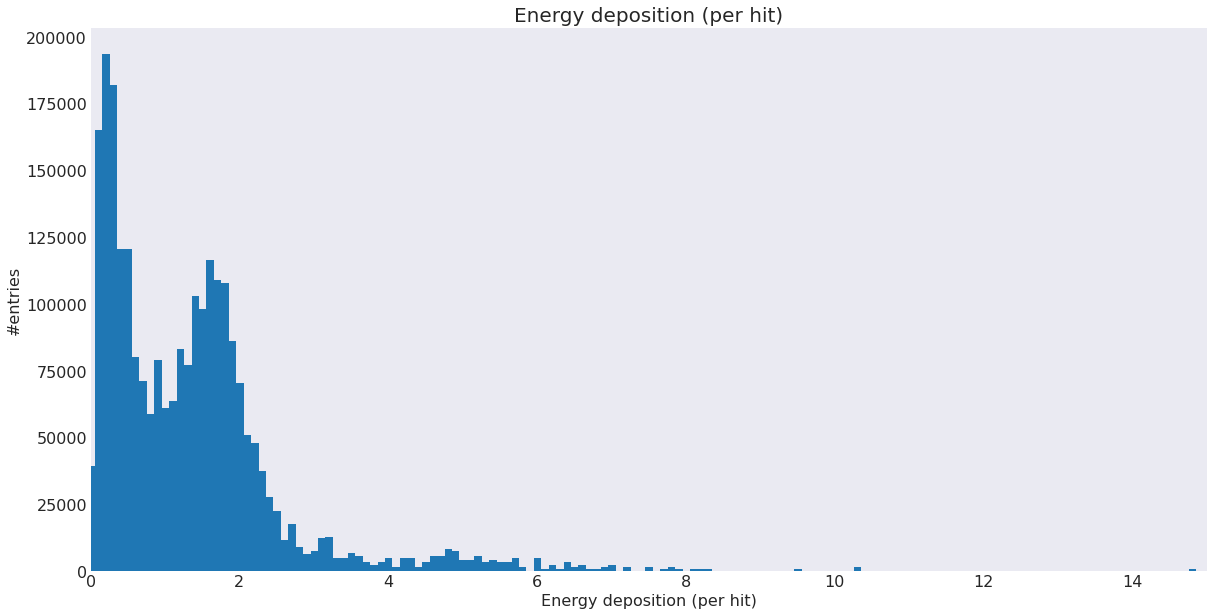

In [16]:
plt.figure(figsize=(20,10))
plt.hist(edeps_per_hit, bins = compute_histogram_bins(edeps_per_hit,0.1))
plt.title("Energy deposition (per hit)", fontsize = 20)
plt.ylabel("#entries", fontsize = 16)
plt.xlabel("Energy deposition (per hit)", fontsize = 16)
plt.xlim(0,15)
plt.show()

### Average energy deposition of cluster vs. #hits in cluster

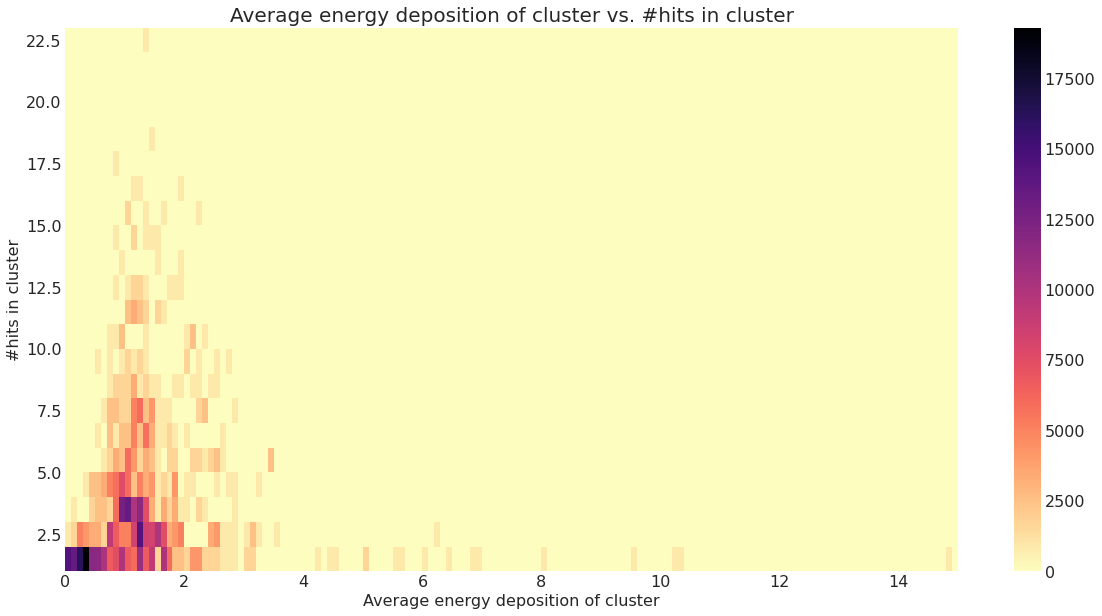

In [17]:
plt.figure(figsize=(20,10))
plt.hist2d(average_edep_clusterhits,num_hits_cluster_2, bins = (compute_histogram_bins(average_edep_clusterhits, 0.1),compute_histogram_bins(num_hits_cluster_2,1)), cmap = "magma_r")
plt.colorbar()
plt.title("Average energy deposition of cluster vs. #hits in cluster", fontsize = 20)
plt.xlabel("Average energy deposition of cluster", fontsize = 16)
plt.ylabel("#hits in cluster", fontsize = 16)
plt.xlim(0,15)
plt.show()

### Time difference of hits in cluster to the first hit

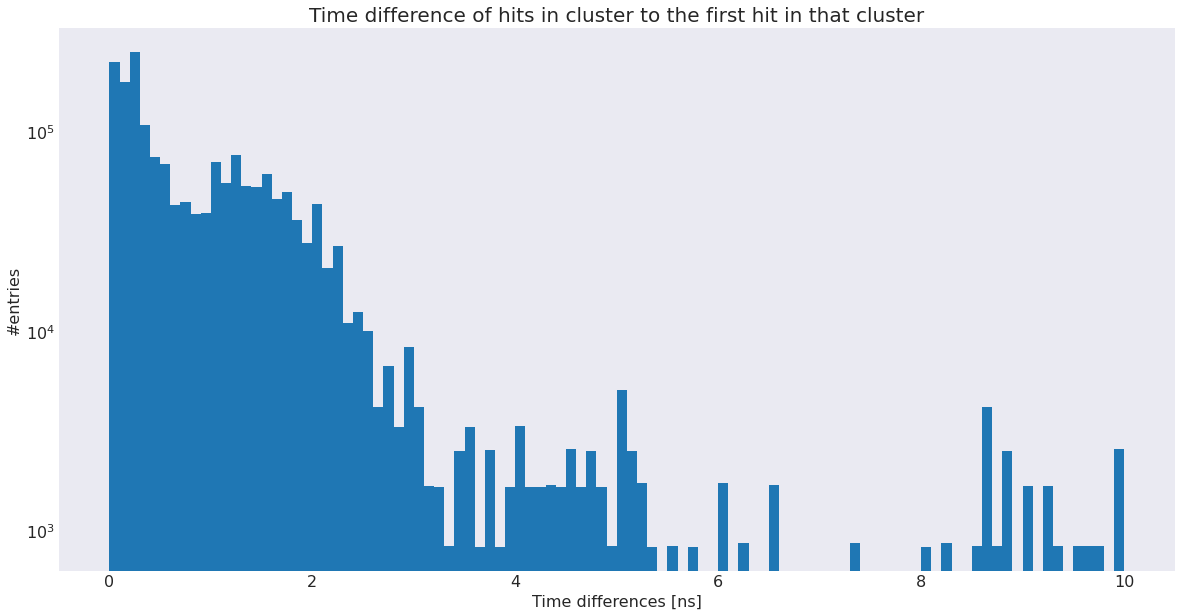

In [18]:
plt.figure(figsize=(20,10))
plt.hist(cluster_time_diff_to_first_hit, bins = compute_histogram_bins(cluster_time_diff_to_first_hit,0.1))
plt.title("Time difference of hits in cluster to the first hit in that cluster", fontsize = 20)
plt.ylabel("#entries", fontsize = 16)
plt.xlabel("Time differences [ns]", fontsize = 16)
plt.yscale("log")
plt.show()

### Time difference of hits in cluster to the first hit vs. energy deposition of that hit

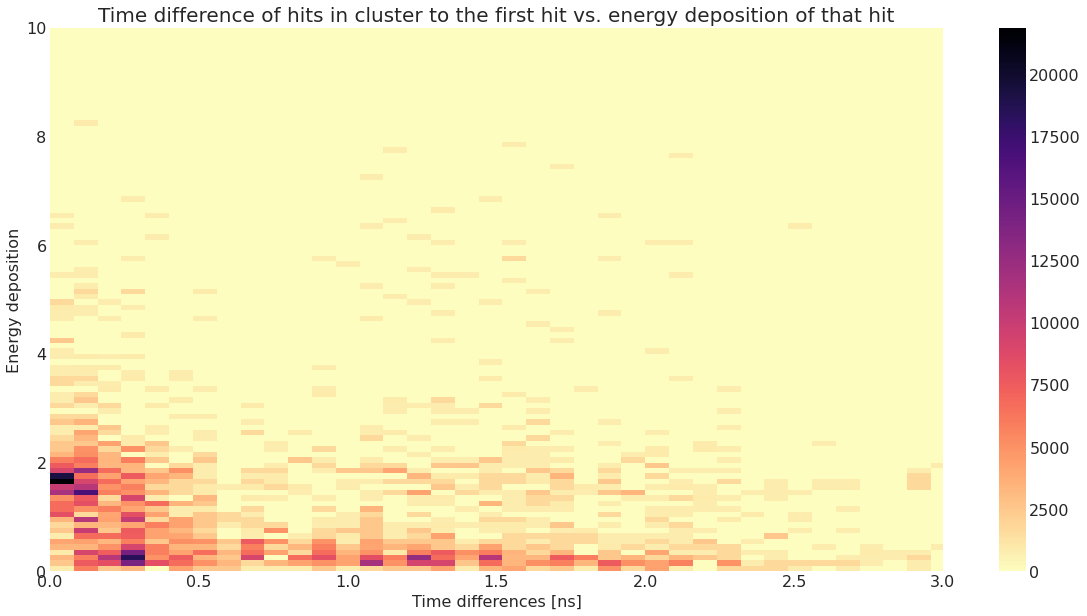

In [28]:
plt.figure(figsize=(20,10))
plt.hist2d(cluster_time_diff_to_first_hit,edeps_per_hit_without_first_hit, bins = (compute_histogram_bins(cluster_time_diff_to_first_hit, 1.6/20),compute_histogram_bins(edeps_per_hit_without_first_hit,0.1)), cmap = "magma_r")
plt.colorbar()
plt.title("Time difference of hits in cluster to the first hit vs. energy deposition of that hit", fontsize = 20)
plt.xlabel("Time differences [ns]", fontsize = 16)
plt.ylabel("Energy deposition", fontsize = 16)
plt.ylim(0,10)
plt.xlim(0,3)
plt.show()